In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from scipy.spatial import distance
from adjustText import adjust_text

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import make_h_combined, PC_axes, get_color_inds, take_names, get_T_inds, angle_between

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','fig4','fig4_BC')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:

def stats_corr(X,y,num_perms = 10):
# Create linear regression object
    
    test_set_size = int(len(X)/10)

    r2 = [None]*num_perms
    mse = [None]*num_perms
    for perm in range(num_perms):

        regr = linear_model.LinearRegression()

        rand_order = np.random.permutation(len(X))

        y_train = y[rand_order[:-test_set_size]]
        X_train = X[rand_order[:-test_set_size], np.newaxis]

        y_test = y[rand_order[-test_set_size:]]
        X_test = X[rand_order[-test_set_size:], np.newaxis]

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)

        r2[perm] = r2_score(y_test, y_pred)
        mse[perm] = mean_squared_error(y_test, y_pred)
        
    return r2,mse

def make_angle_mat(X):
    X = np.squeeze(X).astype(np.float64)

    theta_mat = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        v1 = X[xi,:]
        for yi in range(np.shape(X)[0]):
            v2 = X[yi,:]
            theta_mat[xi,yi] = 180*angle_between(v1, v2)/np.pi
            
    return theta_mat

In [4]:
def plot_task_layout_PCA(h_combined_all,task_nums,figsize = 7,pcs = [0,1],color_set = []):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    ax1 = plt.subplot(1,1,1)
    if len(color_set)<1:
        color_inds, color_inds_nu = get_color_inds()
    else:
        color_inds_nu = color_set
    
    n_trials = len(h_combined_all)
    X_train = h_combined_all[0:n_trials:2,:]
    pca = PCA(n_components = 4)
    fp_pca = pca.fit(X_train)
    
    X_test = h_combined_all[1:n_trials:2,:]
    fp_pca = pca.transform(X_test)
    D_use = fp_pca[:,pcs]
    
    n_trials = int(len(X_test)/len(task_nums))
    
    together = []
    for t_num in range(len(task_nums)):
        c = color_inds_nu[task_nums[t_num]]
        trials_use = range(t_num*n_trials,(t_num+1)*n_trials)
        plt.plot(D_use[trials_use,0],D_use[trials_use,1],'o',c = c,alpha = .2,markersize = 10)
        rule = rules_dict['all'][task_nums[t_num]]
        _, rule_name, _, _ = take_names('fix1',rule)
#         plt.text(np.mean(D_use[trials_use,0])-.01,1.1*np.mean(D_use[trials_use,1]),
#                  rule_name,color = c,fontsize = 20,weight="bold")
        
        together.append((np.mean(D_use[trials_use,0]),np.mean(D_use[trials_use,1]),rule_name,c))
    
    texts = []
    for x, y, s, c in together:
        texts.append(plt.text(x, y, s, color = c, fontsize = 20, weight="bold"))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.set_xlabel('Context Endpt. State PC1',fontsize = 20)
    ax1.set_ylabel('Context Endpt. State PC2',fontsize = 20)
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='k', lw=1))

    task_list = [rules_dict['all'][x] for x in task_nums]
    
    if not os.path.exists(os.path.join(figpath,save_net_name)):
        os.makedirs(os.path.join(figpath,save_net_name))
    
    figname = 'task_layout.pdf'
    plt.savefig(os.path.join(figpath,save_net_name,figname),bbox_inches='tight')
    print(os.path.join(figpath,figname))
    
    plt.show()

In [5]:
def make_dst_mat(X):
    X = np.squeeze(X).astype(np.float64)
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])
    return dst

In [6]:
task_labels = {}
task_labels['all'] = range(15)
task_labels['Category Motif'] = [13, 14]
# task_labels['Decision Motif'] = [10,9]
task_labels['Different Motifs'] = [3,1]

color_set = ['dodgerblue','limegreen','dodgerblue',
             'r','orange','r',
             'steelblue','steelblue','steelblue','steelblue','steelblue',
             'limegreen','orange','plum','plum']

def make_sub_mat(D_concat,T_concat,motif_grp_concat,D_mat,T_mat,labels,color_set = color_set):
    
    D_sub_mat = D_mat[labels,:]
    D_sub_mat = D_sub_mat[:,labels]
    D_sub_mat = np.tril(D_sub_mat,k = -1)
    
    T_sub_mat = T_mat[labels,:]
    T_sub_mat = T_sub_mat[:,labels]
    T_sub_mat = np.tril(T_sub_mat,k = -1)
    
    color_mat = np.matlib.repmat(color_set, len(color_set),1)
    same_motif = (color_mat == color_mat.T)
    motif_grp = same_motif[labels,:]
    motif_grp = motif_grp[:,labels]
    motif_grp = np.tril(motif_grp,k = -1)
    
    if len(D_concat)==0:
        D_concat = D_sub_mat[D_sub_mat>0][:,np.newaxis]
        T_concat = T_sub_mat[D_sub_mat>0][:,np.newaxis]
        motif_grp_concat = motif_grp[D_sub_mat>0][:,np.newaxis]
    else:  
        D_concat = np.concatenate((D_concat,D_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
        T_concat = np.concatenate((T_concat,T_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
        motif_grp_concat = np.concatenate((motif_grp_concat,motif_grp[D_sub_mat>0][:,np.newaxis]),axis = 1)
    return D_concat,T_concat,motif_grp_concat

In [7]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '1'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data_share/rnn/multitask/stepnet/final/all'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [8]:
m

'/Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [9]:
save_net_name = '_'.join((rnn_type,activation,w_init,seed))

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


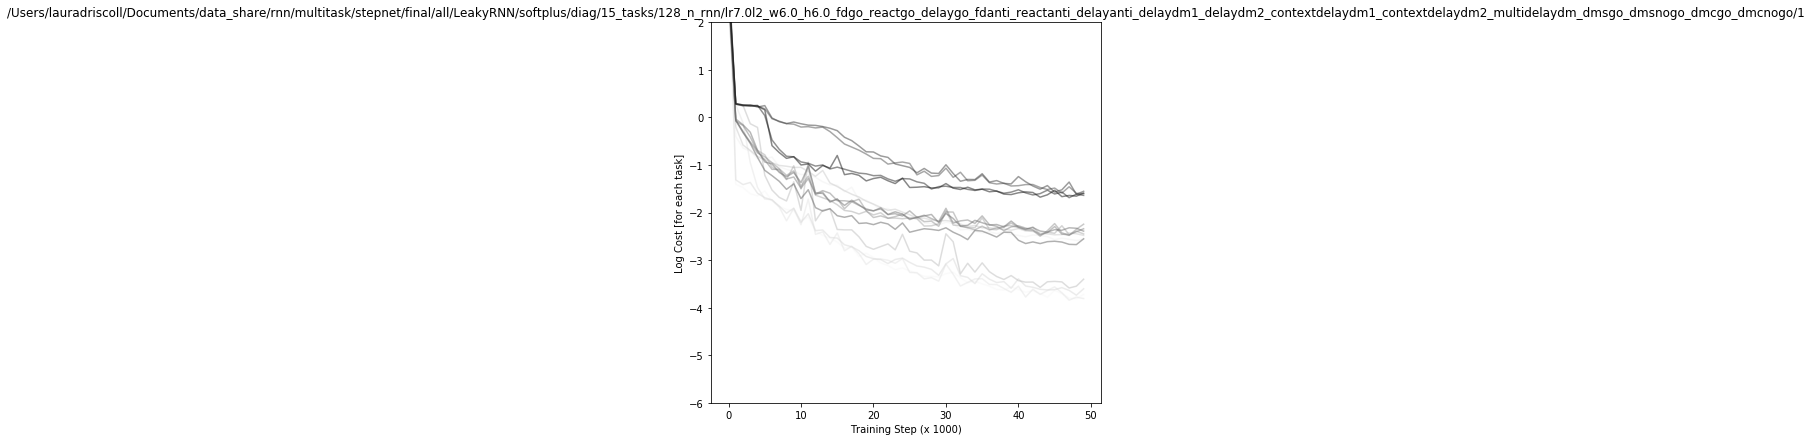

In [10]:
fig = plt.figure(figsize=(7, 7))
cmap=plt.get_cmap('Greys')

for r in range(len(rule_trains)):
        
    fname = os.path.join(m, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
        c = cmap((r+1)/(len(rule_trains)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+rule_trains[r]])
        plt.plot(x,'-',c = c,alpha = .5)
    
ax.set_xlabel('Training Step (x 1000)')
ax.set_ylabel('Log Cost [for each task]')
plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask

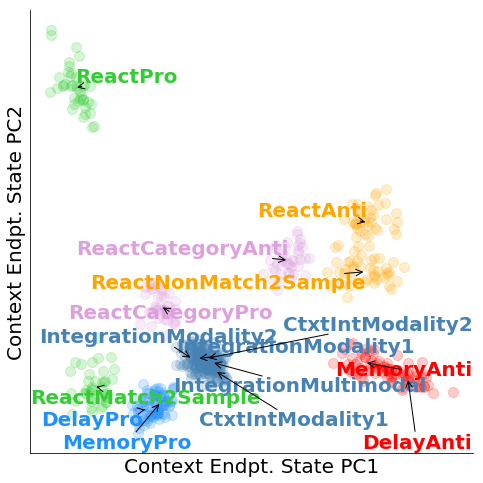

In [12]:
m = '/Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

ckpt_n_dir = []
trial_set = range(80)
task_nums = range(15) # all tasks
batch_size = len(trial_set)
h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1')
plot_task_layout_PCA(h_combined_fix,task_nums,figsize = 7,color_set = color_set,pcs = [0,1])


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn

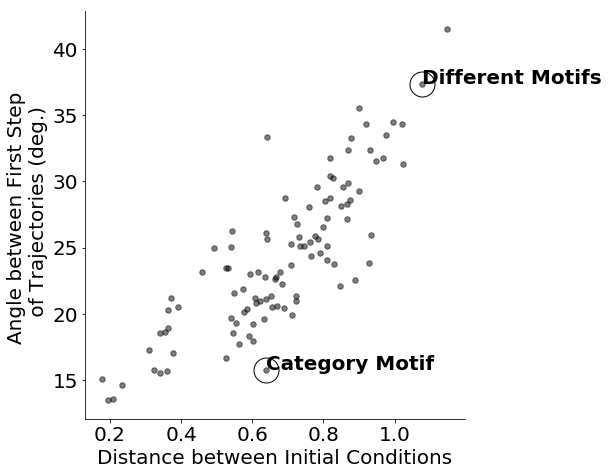

In [13]:
task_nums = range(15) # all tasks
trial_set = range(0,80,10)
h_combined_stim = make_h_combined(m,task_nums,trial_set,'stim1',ind = 1)
h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1',ind = -1)
h_stim_diff = h_combined_stim - h_combined_fix
theta_mat = make_angle_mat(h_stim_diff)
dst_fix = make_dst_mat(h_combined_fix)

figsize = 7
fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})
ax1 = plt.subplot(1,1,1)

D_concat = {}
T_concat = {}
motif_grp_concat = {}
for k in task_labels.keys():
    D_concat[k],T_concat[k],motif_grp_concat[k] = [],[],[]

batch_size = len(trial_set)
for xi in range(batch_size):
    
    dst_fix_stim_type = dst_fix[xi:len(dst_fix):batch_size,:]
    dst_fix_stim_type = dst_fix_stim_type[:,xi:len(dst_fix):batch_size]
    
    theta_mat_stim_type = theta_mat[xi:len(dst_fix):batch_size,:]
    theta_mat_stim_type = theta_mat_stim_type[:,xi:len(dst_fix):batch_size]
    
    for k in task_labels.keys():
        D_concat[k],T_concat[k],motif_grp_concat[k] = make_sub_mat(D_concat[k],T_concat[k],motif_grp_concat[k],
                                                                dst_fix_stim_type,theta_mat_stim_type,
                                                                task_labels[k],color_set = color_set)
    
for k in task_labels.keys():
    if k=='all':
        plt.scatter(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),#,s=30,
                 c = 'k',alpha = .5,s = 30) #(100*motif_grp_concat[k][:,0]+5)
    else:
        plt.plot(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),'ok',markerfacecolor = 'none',
                 markersize = 25,alpha = 1,label = k,linewidth = 5)
        plt.text(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),k,fontweight = 'bold')

plt.xlabel('Distance between Initial Conditions')
plt.ylabel('Angle between First Step \n of Trajectories (deg.)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
if not os.path.exists(os.path.join(figpath,save_net_name)):
    os.makedirs(os.path.join(figpath,save_net_name))

figname = 'theta_v_dst.pdf'
plt.savefig(os.path.join(figpath,save_net_name,figname),bbox_inches='tight')
print(os.path.join(figpath,figname))
    
plt.show()

In [14]:
k = 'all'
D_concat,T_concat,motif_grp_concat = make_sub_mat([],[],[],dst_fix_stim_type,theta_mat_stim_type,
                                                  task_labels[k],color_set = color_set)

X = np.mean(D_concat,axis = 1)
y = np.mean(T_concat,axis = 1)

r2,mse = stats_corr(X,y,num_perms = 1000)

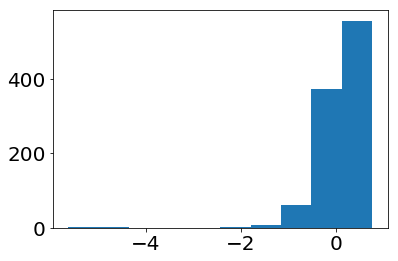

In [15]:
plt.hist(r2)
plt.show()